/Users/anushkadole/scRNA-pancreatic/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.3 anndata==0.10.9 umap==0.5.9.post2 numpy==2.0.2 scipy==1.13.1 pandas==2.3.1 scikit-learn==1.6.1 statsmodels==0.14.5 igraph==0.11.9 pynndescent==0.5.13
... reading from cache file cache/datasets-matrix.h5ad
filtered out 1478 genes that are detected in less than 3 cells


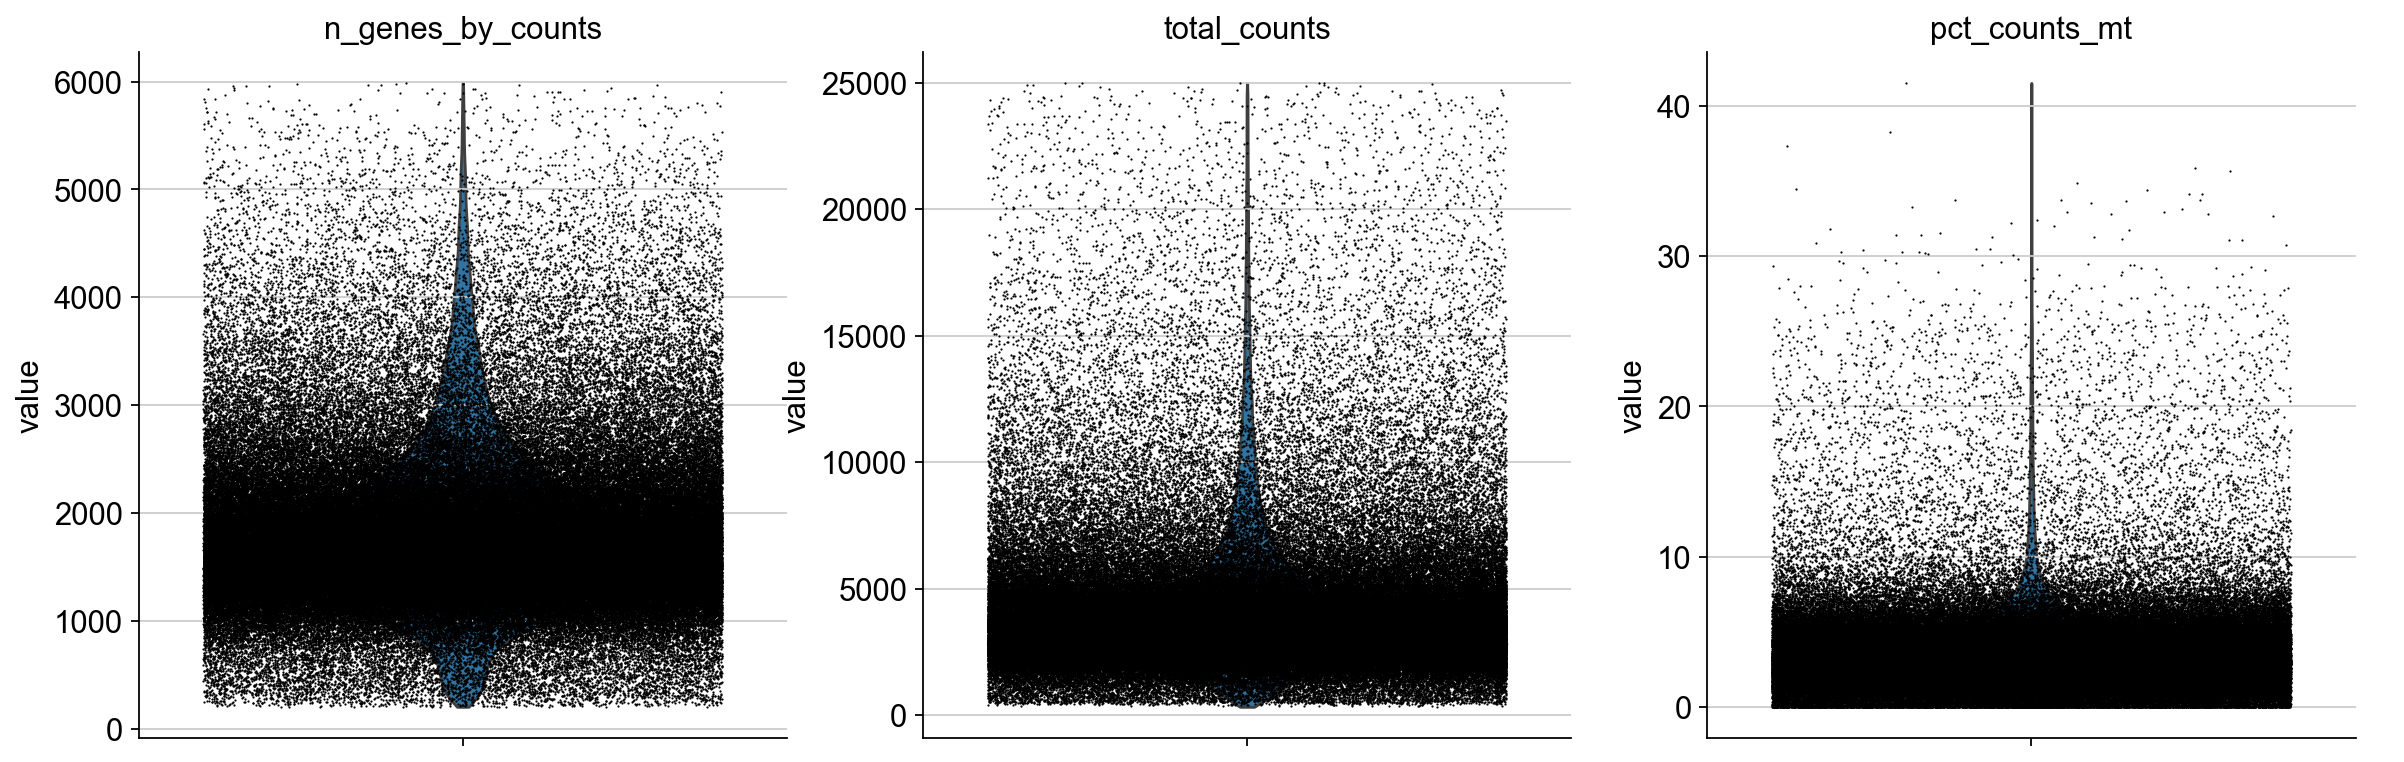

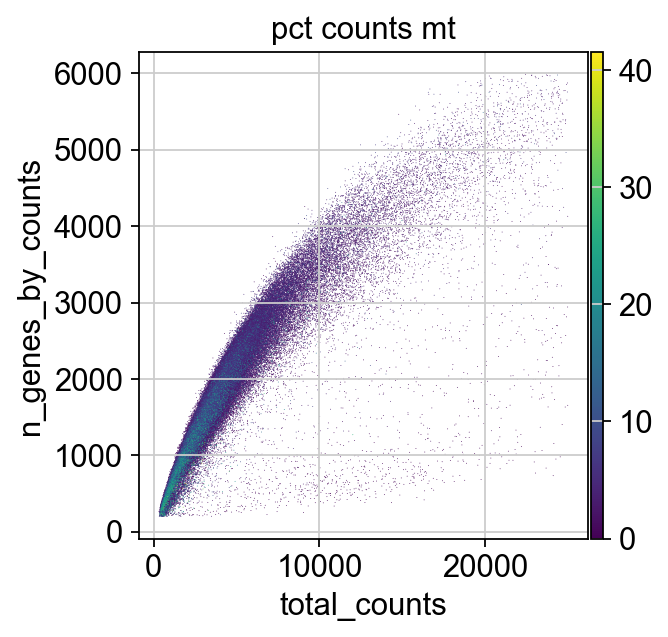

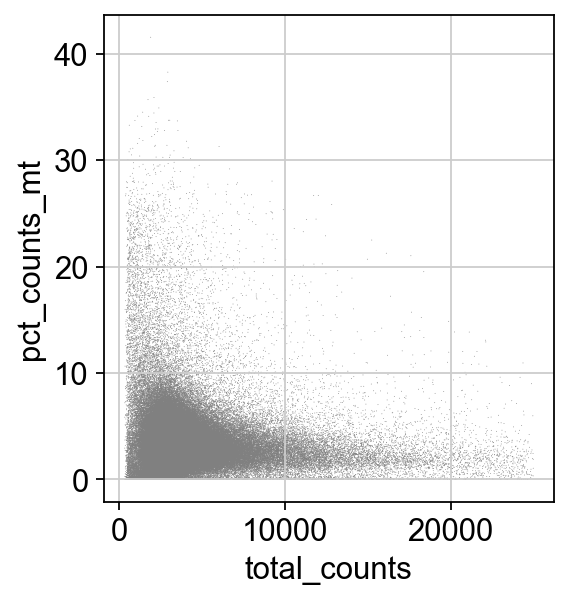

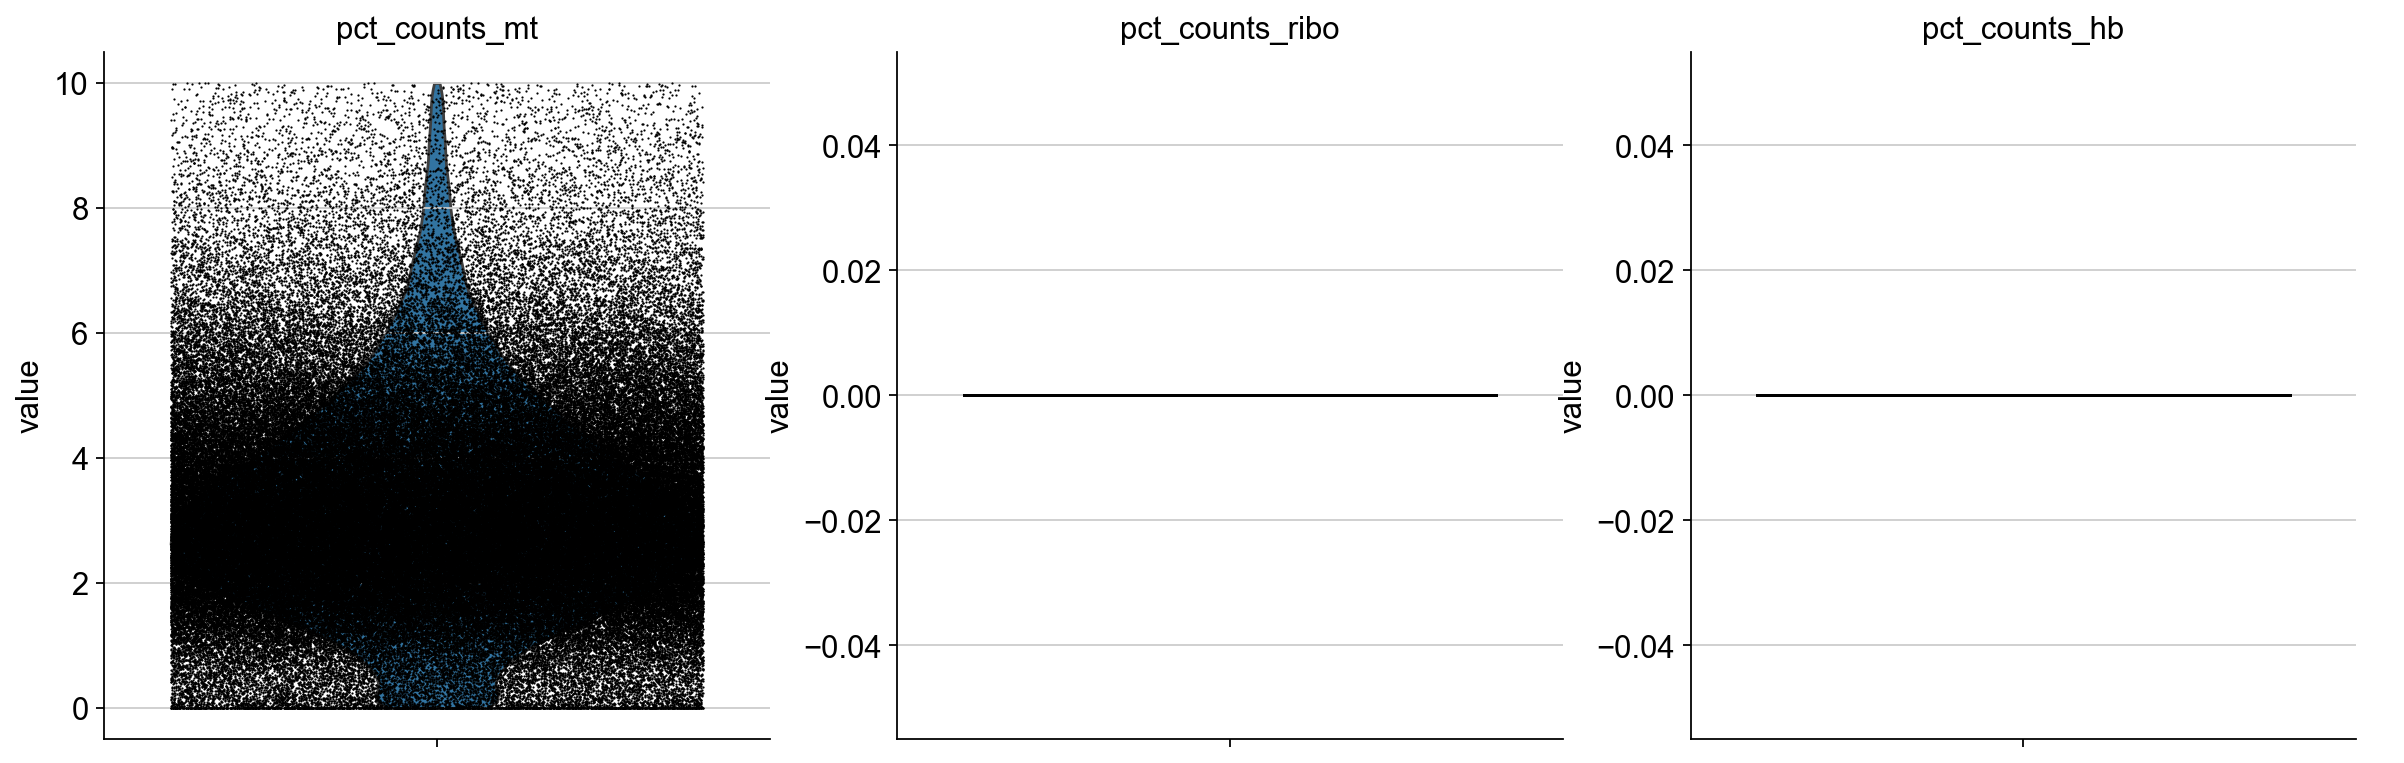

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt


# lines 6 - 29 from: https://www.danli.org/2021/02/03/single-cell-data-analysis-using-scanpy/ 
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

adata = sc.read_10x_mtx(
    "datasets", 
    var_names="gene_symbols",
    cache=True
)

adata.var_names_make_unique()

#filter 20 highest expressed genes
#sc.pl.highest_expr_genes(adata, n_top=20, )

#filtering out the cells with low gene expression/genes that don't show up in many cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

#annotate mitochondrial genes as 'mt' and calculate qc metrics based on 
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var['hb'] = adata.var_names.str.startswith("^HB[^(P)]") #regular expression that chooses all leters after HB besides the capital letter P
#regex is used because pseudogenes have names like HBP1, HBP2, etc 

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.scatter(adata, 'total_counts', 'pct_counts_mt')

adata_cp1 = adata[
    (adata.obs['pct_counts_mt'] < 10) &
    (adata.obs['pct_counts_ribo'] < 20) &
    (adata.obs['pct_counts_hb'] < 5),
    :
].copy()

sc.pl.violin(adata_cp1, ['pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'], jitter=0.4, multi_panel=True)

In [2]:
# Run this in a Jupyter cell
import sys
!{sys.executable} -m pip install scikit-image

You should consider upgrading via the '/Users/anushkadole/scRNA-pancreatic/.venv/bin/python -m pip install --upgrade pip' command.


Dataset shape: (194144, 29065)
Data type: <class 'scipy.sparse._csc.csc_matrix'>
Running Scrublet
filtered out 2439 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 8.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.1%
    Scrublet finished (0:05:19)


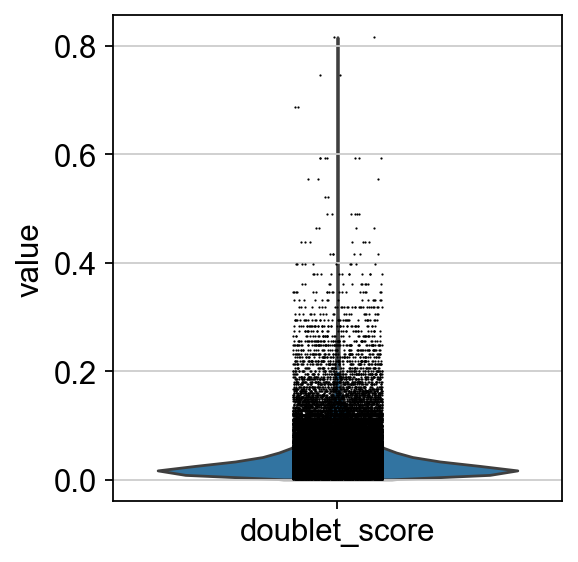

In [4]:
print(f"Dataset shape: {adata_cp1.shape}")
print(f"Data type: {type(adata_cp1.X)}")

# Randomly sample 10k cells for doublet detection
np.random.seed(42)
sample_indices = np.random.choice(adata_cp1.n_obs, size=50000, replace=False)
adata_subset = adata_cp1[sample_indices].copy()

sc.pp.scrublet(adata_subset)
sc.pl.violin(adata_subset, 'doublet_score', groupby=None)